# $\sim$ No-Two-Holes-Touching (NTHT) Mask
In the following code, we generate "from scratch" a new mask for LEM-X with the following characteristics:
-  Open-fraction in the range $0.25 \leq of \leq 0.33$ (so we start from 0.33 of original open fraction)
-  1040 elements along the fine (X) direction
-  19 elements along the coarse (Y) direction
-  0.25 mm pitch in the fine (X) direction
-  13.8 mm pitch in the coarse (Y) direction
-  1.8 mm ribs
-  Maximum homogeneity along row and columns


In [1]:
%matplotlib ipympl
import numpy as np
from mask_utils import *
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
yele = 19
xele = 1040
nele = xele * yele

In [3]:
focal = 202.9
mpitch_x = 0.25
mpitch_y = 13.8
ribsize_y = 1.8
ELXDIM = 0.25
ELYDIM = 0.3

## MASK CODE

To generate the code we use Theorem 5.18 (iii) from Baumert L. D. 1971, "Lecture Notes in Mathematics No. 182", "Cyclic Difference Sets"

Using biquadratic residues for primes $v = 4x^2 + 9$ with $x$ odd

In [4]:
# Generating the code using the nearest prime which satisfies the ura33 conditions
prime_gen =20173
full_code=bura33(prime_gen)

## MASK SPATIAL HOMOGENEITY
Using a brute force approach, we try to determine the cyclic code shift which
maximize the mask symmetry.
To do that, for each shift we calculate the variance matrix and estimate its symmetry

Please note that this is a long process...

In [5]:
res = np.zeros(prime_gen)

for ss in range(0, prime_gen):
    shifted = np.roll(full_code, ss)
    mask = shifted[0:nele].reshape(xele, yele, order='C')
    of =  np.sum(mask)/mask.size
    rmatrix = np.ones(mask.shape)
    rmatrix[mask <1] = -1 * (1.0 - 1.0/(nele * of)) * of/(1.0-of)
    
    variance = decode_var(mask, rmatrix, np.ones(mask.shape), focal, mpitch_x, mpitch_y)
    residual = abs(variance - np.flip(variance, axis=None))
    
    res[ss] = np.sum(residual)


As espected, rows don't really "suffer" from big differences (each one has 1040 elements, so every difference is diluted). Still, we can find a cyclic shift wich minimize the differences along the cols.

Optimal code shift: 19966
Original OF: 0.33289473684210524


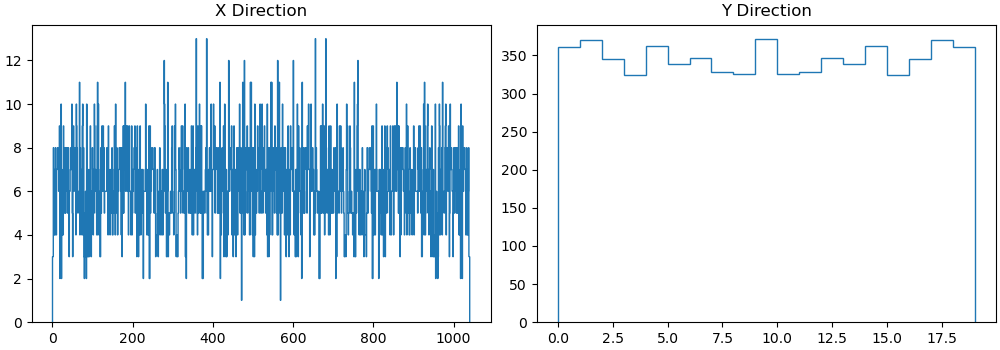

In [6]:
print("Optimal code shift:", np.argmin(res))

shifted = np.roll(full_code, np.argmin(res))
mask_base = shifted[0:nele].reshape(xele, yele, order='C')

xcollapse = mask_base.sum(axis=1)
ycollapse = mask_base.sum(axis=0)

original_of =  np.sum(mask_base)/mask_base.size
print("Original OF:", original_of)


# Plotting collapsed projections

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3.5))
axs[0].set_title('X Direction')
axs[0].stairs(xcollapse)
axs[1].set_title('Y Direction')
axs[1].stairs(ycollapse)
plt.show()

## MASK WITHOUT RIBS
We try to find the best geometric solution for this mask, considering that we don't need ribs before the first row and after the last. This design give us a 260.4 mm mask (in Y) and of course a 260 mm mask in X. The total number of ribs is 18

In [7]:
# Now we upscale the mask 
upf_x = mpitch_x / ELXDIM #=1, no upscaling needed
upf_y = mpitch_y / ELYDIM

mask_original = upscale(mask_base, upf_y, upf_x)
rmatrix = np.ones(mask_original.shape)
rmatrix[mask_original < 1] = -1 * (1.0 - 1.0/(nele * original_of)) * original_of/(1.0-original_of)

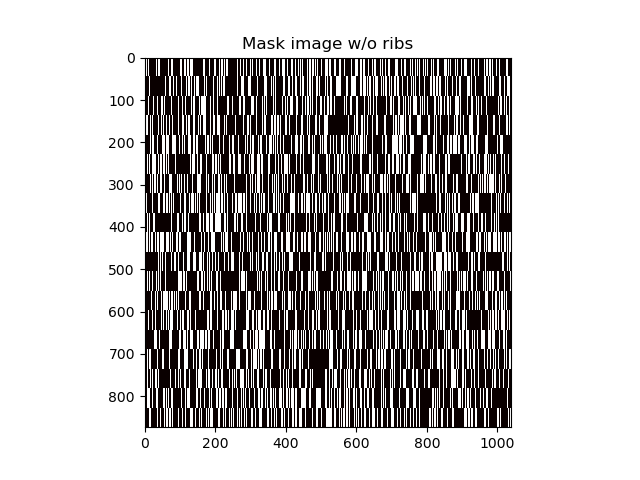

In [8]:
plt.figure()
plt.title('Mask image w/o ribs')
plt.imshow(mask_original.T, cmap=cm.hot,  interpolation='nearest', aspect=ELYDIM/ELXDIM)
plt.show()

## RIBS
Now we force to zero the ribs (along the mask rows).

In [9]:
mask = np.zeros(mask_original.shape)
mask[mask_original == 1] = 1

# Select ribs index from the upscaled mask
selected_rows = []
for start in range(0, mask_original.shape[1],  int(mpitch_y / ELYDIM)):
    selected_rows.extend(range(start, min(start + int(ribsize_y/ELYDIM), mask.shape[1])))

# Force the selected rows to 0
mask[:, selected_rows] = 0
rmatrix[:, selected_rows] = 0
#Remove the first ribsize_y/ELYDIM rows
mask = mask[:, int(ribsize_y/ELYDIM)-1:-1]

print("Total mask dimension [elements]:", mask.shape)
print("Total mask dimension [mm]:", mask.shape[0] * ELXDIM, "x",  mask.shape[1] * ELYDIM)
print("Ribs dimension [elements]", ribsize_y/ELYDIM)
print("Ribs step [elements]", mpitch_y / ELYDIM)

Total mask dimension [elements]: (1040, 868)
Total mask dimension [mm]: 260.0 x 260.4
Ribs dimension [elements] 6.0
Ribs step [elements] 46.00000000000001


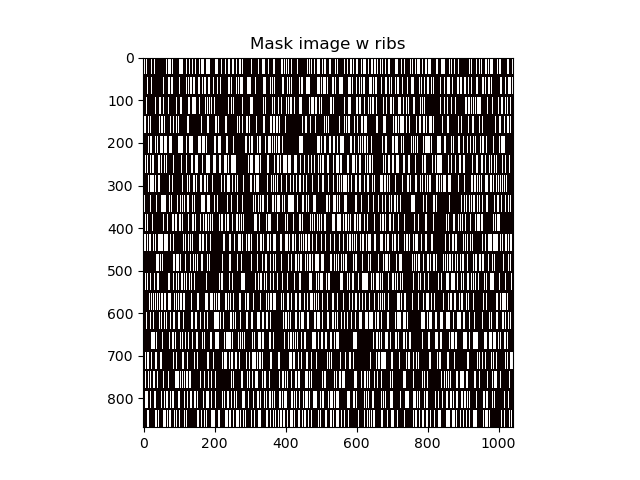

In [10]:
plt.figure()
plt.title('Mask image w ribs')
plt.imshow(mask.T, cmap=cm.hot,  interpolation='nearest', aspect=ELYDIM/ELXDIM)
plt.show()

## Open Fraction

In [11]:
openfraction = np.sum(mask)/mask.size
print("Final open fraction", openfraction) 

Final open fraction 0.2910747518610422


## TEST SKY IMAGE

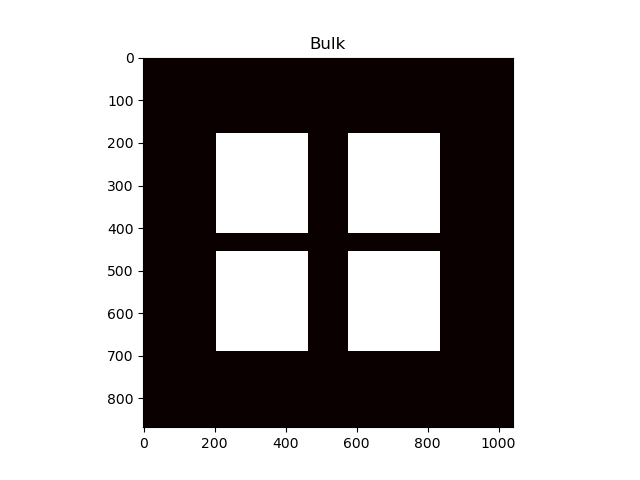

In [12]:
#We need to create a new bulk...
det_ext_border_x = 157.996
det_ext_border_y = 153.176
det_int_border_x = 28.204
det_int_border_y = 12.824


#Defining bulk array
bulk = np.ones(mask.shape)

#Removing non-sensitive regions along the X direction
bulk[0: int(round((bulk.shape[0] -  det_ext_border_x/ELXDIM)/2)),      :] = 0
bulk[-int(round((bulk.shape[0] -  det_ext_border_x/ELXDIM)/2)) : ,      :] = 0
bulk[int(round((bulk.shape[0] -  det_int_border_x/ELXDIM)/2)) : -int(round((bulk.shape[0] -  det_int_border_x/ELXDIM)/2))  ,      :] = 0
#Removing non-sensitive regions along the Y direction
bulk[:,      0: int(round((bulk.shape[1] -  det_ext_border_y/ELYDIM)/2))] = 0
bulk[:,      -int(round((bulk.shape[1] -  det_ext_border_y/ELYDIM)/2)) : ] = 0
bulk[:,      int(round((bulk.shape[1] -  det_int_border_y/ELYDIM)/2)) : -int(round((bulk.shape[1] -  det_int_border_y/ELYDIM)/2))  ] = 0

plt.figure()
plt.title('Bulk')
plt.imshow(bulk.T, cmap=cm.hot,  interpolation='nearest', aspect=ELYDIM/ELXDIM)
plt.show()

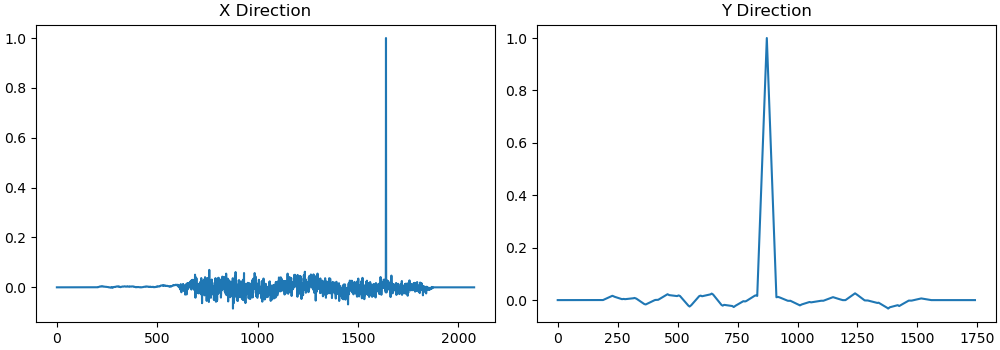

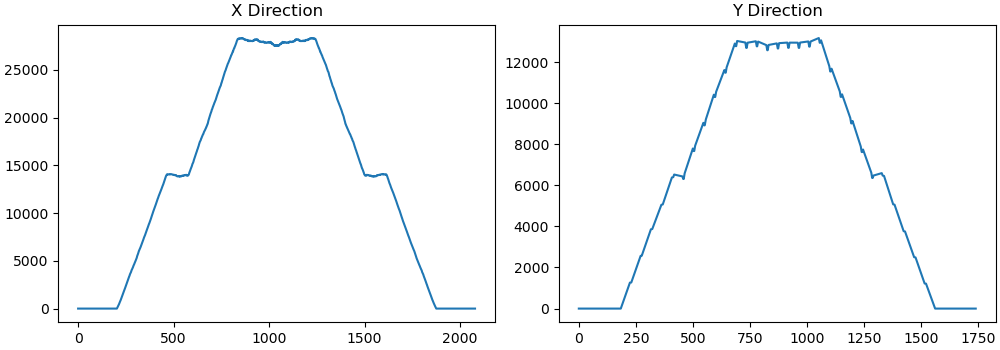

In [13]:
sky = decode(fshift(mask, -600, 0)*bulk, rmatrix, bulk)
peak = np.max(sky)
peak_p = np.unravel_index(np.argmax(sky), sky.shape)


variance = decode_var(mask*bulk, rmatrix, bulk, 202.9, ELXDIM, ELYDIM)

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3.5))
axs[0].set_title('X Direction')
axs[0].plot(sky[:, peak_p[1]]/peak)
axs[1].set_title('Y Direction')
axs[1].plot(sky[peak_p[0], :]/peak)
plt.show()

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3.5))
axs[0].set_title('X Direction')
axs[0].plot(variance[:, peak_p[1]])
axs[1].set_title('Y Direction')
axs[1].plot(variance[peak_p[0], :])
plt.show()

# COMPARING WITH WFM


In [14]:
mask_wfm, hdmask = read_mask_bulk('wfm_mask.fits', 2, header_out=True, verbose=False)
rmatrix_wfm = read_mask_bulk('wfm_mask.fits', 3, verbose=False)
bulk_wfm = read_mask_bulk('wfm_mask.fits', 4, verbose=False)
bulk_wfm[bulk_wfm < 1] = 0

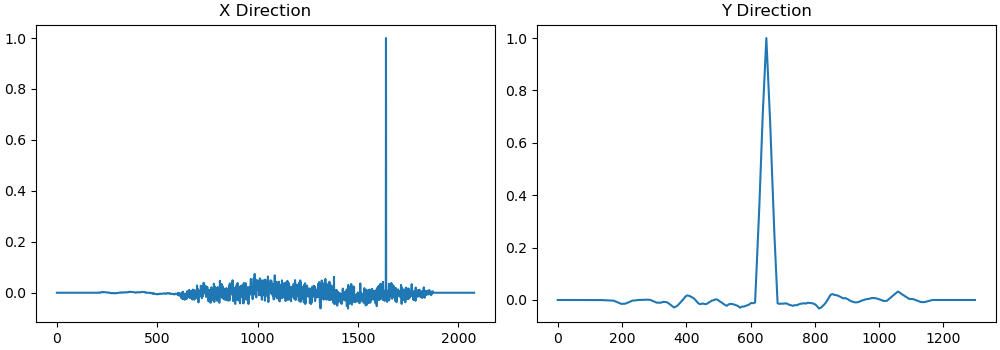

In [15]:
sky_wfm = decode(fshift(mask_wfm, -600, 0) * bulk_wfm, rmatrix_wfm, bulk_wfm)
peak_wfm = np.unravel_index(np.argmax(sky_wfm), sky_wfm.shape)

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3.5))
axs[0].set_title('X Direction')
axs[0].plot(sky_wfm[:, peak_wfm[1]]/np.max(sky_wfm) )

axs[1].set_title('Y Direction')
axs[1].plot(sky_wfm[peak_wfm[0], :]/np.max(sky_wfm))
plt.show()

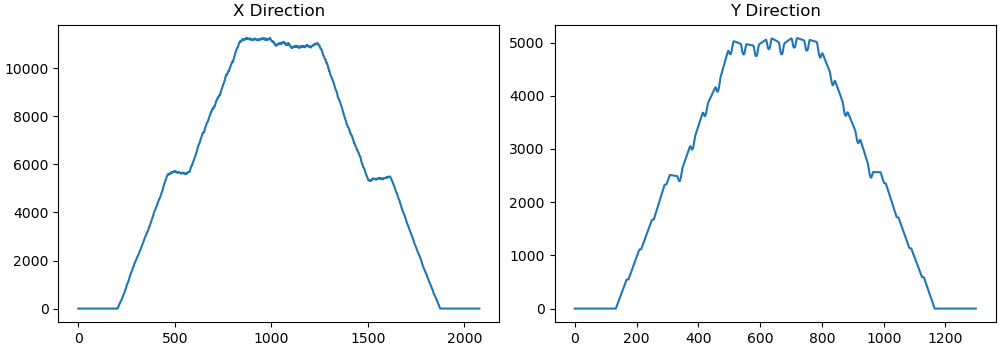

In [16]:
variance_wfm = decode_var(mask_wfm*bulk_wfm, rmatrix_wfm, bulk_wfm, focal, 0.25, 0.4)

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3.5))
axs[0].set_title('X Direction')
axs[0].plot(variance_wfm[:, peak_wfm[1]])
axs[1].set_title('Y Direction')
axs[1].plot(variance_wfm[peak_wfm[0], :])
plt.show()

## Checking significance distribution for a flat bkg

In [17]:
dummy_det = np.random.poisson(lam=0.1, size=mask.shape) * bulk
dummy_det_wfm = np.random.poisson(lam=0.1, size=mask_wfm.shape) * bulk_wfm


dummy_sky = decode(dummy_det, rmatrix, bulk)
dummy_sky_wfm = decode(dummy_det_wfm, rmatrix_wfm, bulk_wfm)

variance = decode_var(dummy_det, rmatrix, bulk, focal, ELXDIM, ELYDIM)
variance_wfm = decode_var(dummy_det_wfm, rmatrix_wfm, bulk_wfm, focal, 0.25, 0.4)


variance_clipped = np.clip(variance, a_min=1E-8, a_max=np.sum(dummy_det)) if np.any(variance <= 0) else variance
variance_clipped_wfm = np.clip(variance_wfm, a_min=1E-8, a_max=np.sum(dummy_det_wfm)) if np.any(variance_wfm <= 0) else variance_wfm

dummy_sky = decode(dummy_det, rmatrix, bulk)
dummy_sky_wfm = decode(dummy_det_wfm, rmatrix_wfm, bulk_wfm)

dummy_sign = dummy_sky/np.sqrt(variance_clipped)
dummy_sign_wfm = dummy_sky_wfm/np.sqrt(variance_clipped_wfm)


dummy_sign = dummy_sign[205:-205, 224:-224 ]
dummy_sign_wfm = dummy_sign_wfm[205:-205, 134:-134 ]

dummy_sign_h, bins = np.histogram(dummy_sign.reshape(dummy_sign.size), bins=1000,  density=True)
dummy_sign_h_wfm, _ = np.histogram(dummy_sign_wfm.reshape(dummy_sign_wfm.size), bins=bins,  density=True)

In [18]:
from scipy.optimize import curve_fit
def gauss(x, A, x0, sigma):
    return A * np.exp(-(x - x0)**2 / (2 * sigma**2))


binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])

popt, _ = curve_fit(gauss, xdata=binscenters, ydata=dummy_sign_h, p0=[1, 0, 1.0])
popt_wfm, _ = curve_fit(gauss, xdata=binscenters, ydata=dummy_sign_h_wfm, p0=[1, 0, 1.0])

print("Sigma:", popt[2])
print("Sigma WFM:", popt_wfm[2])

Sigma: 1.0022932300110161
Sigma WFM: 1.0078179728841985


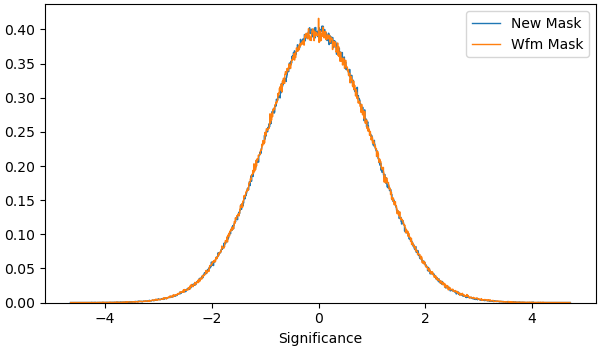

In [19]:
fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(6, 3.5))
plt.stairs(dummy_sign_h, bins, label="New Mask")
plt.stairs(dummy_sign_h_wfm, bins, label="Wfm Mask")
plt.xlabel("Significance")
plt.legend()
plt.show()